In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score
import random 

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


In [2]:
def create_ds(samples_num):
    images = []
    labels = []
    for i in range(samples_num):
        img = np.zeros((50,50), dtype=np.float32) # Image created with 50x50 zeroes i.e full black image.  
        x = np.random.randint(0,50) # Random int value for x coordinate
        y = np.random.randint(0,50) # Random int value for y coordinate

        img[x,y] = 255.0 # Could use 1 directly i.e normalized, keeping it as it is due to problem statement

        images.append(img / 255.0) # normalizing it to 1 for white and 0 for black, keeping it as 255 will increase model load.
        labels.append([x / 49.0, y / 49.0]) # normalizing pixel coordinates
    
    images = np.array(images) 
    labels = np.array(labels)
    print(images.shape)# (N,50,50)
    images = np.expand_dims(images, axis=-1) # (N,50,50,1)
    return images, labels



In [3]:
#creating the neural network model
def build_model():
    model = tf.keras.models.Sequential([
        Input(shape=(50,50,1)), # Input Layer
        Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'), # 2D convolutional layer with 8 feature extractor kernels of size 3,3 with relu activataion and unchanged spatial dimension
        MaxPooling2D((2,2)), # Reducing spatial dimension (50,50,8) -> (25,25,8)
        Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'), # 2D convolutional layer with 16 feature extractor kernels of size 3,3 with relu activataion and unchanged spatial dimension
        MaxPooling2D((2,2)),  # Reducing spatial dimension (25,25,8) -> (12,12,16)
        Flatten(), # Flattening 12 × 12 × 16 feature maps -> 2304 sized vector
        Dense(64, activation='relu'), # Dense Layer with 64 neurons
        Dense(2) # 2 layer representing output as normalized (x,y) coordinates
    ])

    model.compile(
        optimizer='adam', # Adam optimizer: adaptive learning rate optimization algorithm
        loss='mse', # Mean Squared Error loss — suitable for regression (predicting x, y coordinates)
        metrics=['accuracy', 'mae'] # Mean Absolute Error — interpretable average pixel prediction error, Accuracy is not needed but still used.
        ) 
    return model


In [4]:
X_train, y_train = create_ds(5000) # 5000 images sample for training
X_test, y_test = create_ds(1000) # 1000 images sample for testing

(5000, 50, 50)
(1000, 50, 50)


In [5]:
print(X_train.shape)
print(y_train[0])

(5000, 50, 50, 1)
[0.7755102  0.57142857]


In [6]:
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,898 (581.63 KB)

 Trainable params: 148,898 (581.63 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# early stopping to stop model from overtraining
early_Stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-6,
    restore_best_weights=True,
    verbose=1
)
# checkpoints to store the model
checkpoint = ModelCheckpoint(
    'best_pixel_detector.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
# Reducing Lr Dynamicaly
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)
# Extending Callback class to log LR 
class LrLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = self.model.optimizer.learning_rate.numpy()


In [8]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64, # 64 images per batch with 78 batches
    validation_split=0.2, # validation split to be 20$
    callbacks=[early_Stopping, checkpoint, lr_reducer]
    )

Epoch 1/50


59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8517 - loss: 0.1321 - mae: 0.2743
Epoch 1: val_loss improved from None to 0.00787, saving model to best_pixel_detector.keras

Epoch 1: finished saving model to best_pixel_detector.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9305 - loss: 0.0586 - mae: 0.1627 - val_accuracy: 0.9600 - val_loss: 0.0079 - val_mae: 0.0606 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9777 - loss: 0.0054 - mae: 0.0456
Epoch 2: val_loss improved from 0.00787 to 0.00287, saving model to best_pixel_detector.keras

Epoch 2: finished saving model to best_pixel_detector.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9805 - loss: 0.0044 - mae: 0.0401 - val_accuracy: 0.9860 - val_loss: 0.0029 - val_mae: 0.0343 - learning_rate: 0.0010
Epoch 3/50
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9807 - loss: 0.0024 - mae: 0.0300
Epoch 3: val_loss improved from 0.00287 to 0.00148, saving model to

In [9]:
# Model evaluation on test data
model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9900 - loss: 7.7760e-05 - mae: 0.0058


[7.77598688728176e-05, 0.9900000095367432, 0.0057908776216208935]

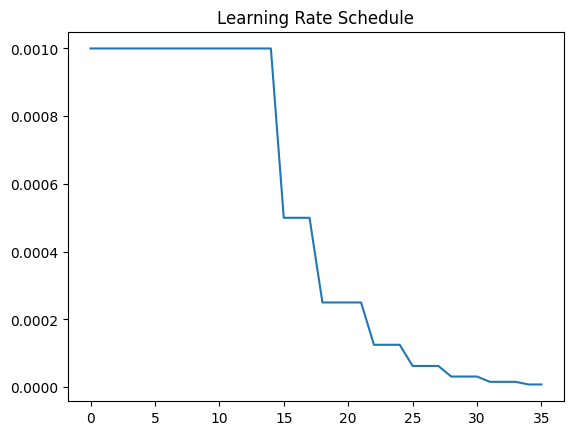

In [10]:
# Plot LR
plt.plot(history.history['learning_rate'])
plt.title("Learning Rate Schedule")
plt.show()


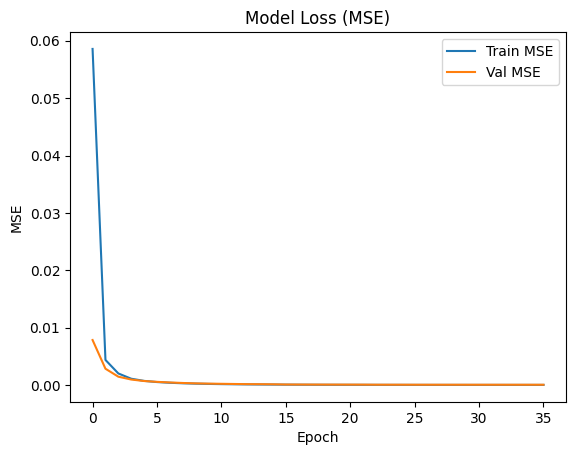

In [11]:
import matplotlib.pyplot as plt

# Plot Loss (MSE)
plt.figure()
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()



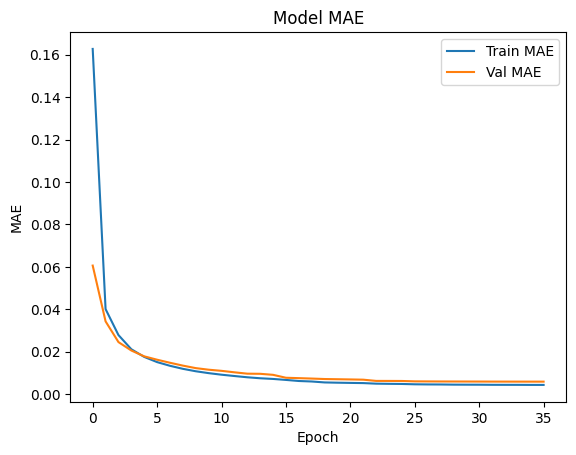

In [12]:
# Plot metric MAE 
plt.figure()
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [13]:

tx, ty = create_ds(1000)
pred = model.predict(tx)
pred = pred * 49
ty = ty * 49
distance = np.linalg.norm(pred - ty, axis=1) # getting euclidian distance for all the images row by row

print("Mean Pixel Distance", np.mean(distance)) # average pixel distance
print("Median Pixel Error:", np.median(distance)) # median of pixel distances
print("Maximum Pixel Distance", np.max(distance)) # maximum pixel distance recorded
print("Minimum Pixel Distance", np.min(distance)) # minimum pixel distance recorded

print("Pearson correlation coefficient",np.corrcoef(ty[:,0], pred[:,0]))
from sklearn.metrics import r2_score
# Compute R² for both coordinates
r2 = r2_score(ty, pred)
print("R² Score:", r2)


(1000, 50, 50)
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Pixel Distance 0.4351858710384309
Median Pixel Error: 0.3252141005944036
Maximum Pixel Distance 4.662376044436191
Minimum Pixel Distance 0.010043721397075144
Pearson correlation coefficient [[1.         0.99955914]
 [0.99955914 1.        ]]
R² Score: 0.9990946472283431


In [14]:
# function to create heatmap
def draw_heatmap(center_x, center_y, size=50, sigma=3):
    x = np.arange(size)
    y = np.arange(size)
    xx, yy = np.meshgrid(x, y)

    heatmap = np.exp(-((xx - center_x)**2 +
                       (yy - center_y)**2) / (2*sigma**2))
    return heatmap


(1, 50, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[19.701632  8.061314]]


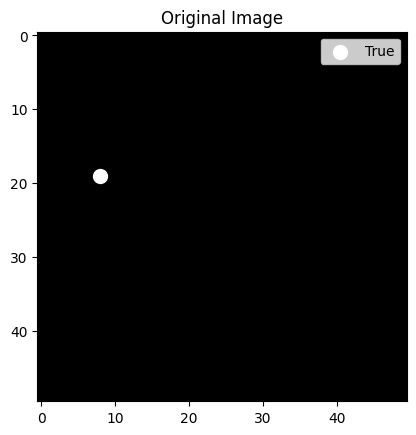

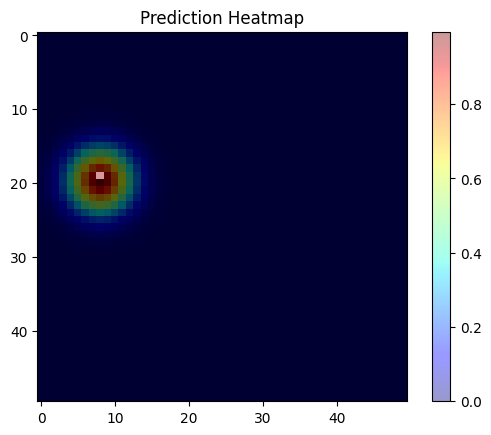

In [15]:
tx, ty = create_ds(1)
pred = model.predict(tx)
ty = ty * 49
pred = pred * 49
print(pred)
pred = pred[0]
ty = ty[0]
heatmap = draw_heatmap(pred[1], pred[0])

# drawing original image
plt.figure()
plt.imshow(tx[0], cmap='gray')
plt.scatter(ty[1], ty[0], c='white', s=100, label="True")
plt.title("Original Image")
plt.legend()
plt.show()

# drawing original image with heatmap overlay
plt.imshow(tx[0], cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.4)
plt.title("Prediction Heatmap")
plt.colorbar()
plt.show()


In [16]:
# Comparision model on why I used convolutional layers in initial layers, which is for better localization.
# model without convolutional layers 
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(50,50,1)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])
model.compile(
    optimizer='adam',
    loss="mse",
    metrics=['accuracy']
    )

model.summary()
print(X_train.shape)
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_Stopping, lr_reducer]
    )



f:\deepedge\env\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 2500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       160,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,194 (625.76 KB)

 Trainable params: 160,194 (625.76 KB)

 Non-trainable params: 0 (0.00 B)

(5000, 50, 50, 1)
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5583 - loss: 0.1772 - val_accuracy: 0.6820 - val_loss: 0.0778 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8255 - loss: 0.0595 - val_accuracy: 0.8280 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9145 - loss: 0.0375
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9290 - loss: 0.0330 - val_accuracy: 0.8650 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9635 - loss: 0.0182 - val_accuracy: 0.8790 - val_loss: 0.0322 - learning_rate: 5.0000e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9787 - loss: 0.0122 - val_accuracy: 0.8940 - val_loss: 0.0276 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best ep

(1, 50, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[22.852089 24.995111]]


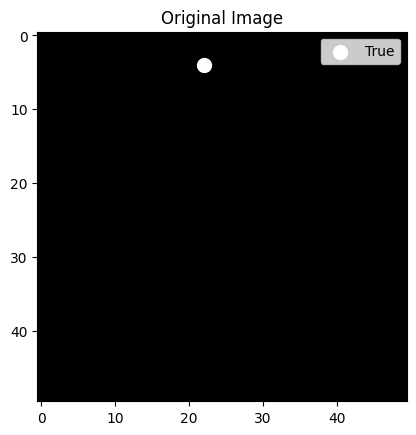

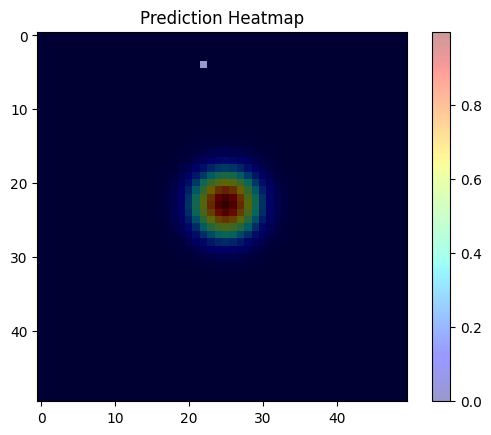

In [17]:
tx, ty = create_ds(1)
pred = model.predict(tx)
ty = ty * 49
pred = pred * 49
print(pred)
pred = pred[0]
ty = ty[0]
heatmap = draw_heatmap(pred[1], pred[0])


# drawing original image
plt.figure()
plt.imshow(tx[0], cmap='gray')
plt.scatter(ty[1], ty[0], c='white', s=100, label="True")
plt.title("Original Image")
plt.legend()
plt.show()

# drawing original image with heatmap overlay
plt.imshow(tx[0], cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.4)
plt.title("Prediction Heatmap")
plt.colorbar()
plt.show()


(1, 50, 50)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[[12.959783 16.047194]]


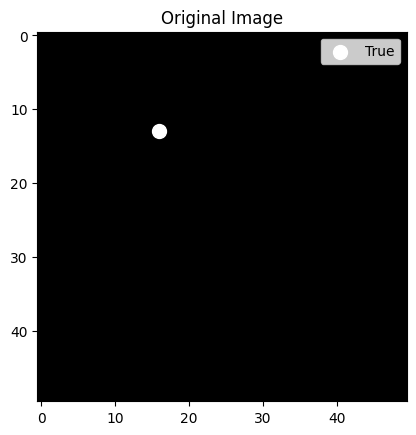

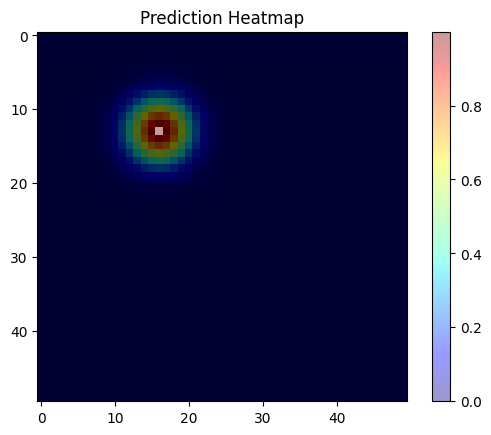

In [19]:
# load model and predict
model = tf.keras.models.load_model("best_pixel_detector.keras")
tx, ty = create_ds(1)
pred = model.predict(tx)
ty = ty * 49
pred = pred * 49
print(pred)
pred = pred[0]
ty = ty[0]
heatmap = draw_heatmap(pred[1], pred[0])

# drawing original image
plt.figure()
plt.imshow(tx[0], cmap='gray')
plt.scatter(ty[1], ty[0], c='white', s=100, label="True")
plt.title("Original Image")
plt.legend()
plt.show()

# drawing original image with heatmap overlay
plt.imshow(tx[0], cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.4)
plt.title("Prediction Heatmap")
plt.colorbar()
plt.show()
